## Predicting Default Payment Credit Card Analysis

Author: Quang Tuan (Finn) Pham 

Created Date: June 10th, 2024


### A. INTRODUCTION:

* In this project, I am aiming to utilize different regression models to predict whether users will experience default payment in the next month using their account information and other personal factors such as age, gender and marriage status. To define what __default payment__ is, James Chen, through an article on Investopedia, states that the failure of borrowers to make required repayments on a debt for businesses or lenders in general. This issue may pose significant impacts credit card users as it may damage users' credit scores as well as their ability to borrow in the future.

* The dataset used in this project was a collection of credit card users in Taiwan, collected by the Department of Information at Chung Hua University and the Department of Civil Engineering at Tangkam University in Taiwan.

* Source for dataset: https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset


### B. METHODS:
* In this section, I will be outlining the main components of my analysis:
    - __Exploratory data analysis__: retrieving dataset as well as important information (through summary statistics and visualizations) on key features of the data.
    - __Feature preprocessing__: performing scaling on features of our data (scaling, encoding, etc.) to ensure that our models will provide meaningful results.
    - __Hyperparameter tuning__: Finding the optimal hyperparamters for each of our model. 
    - __Deployment__: Conclude on the best model to perform predicting on the testing data.

### C. EXPLORATORY DATA ANALYSIS:
* First, we begin by importing relevant libraries and dataset:

In [1]:
import os

%matplotlib inline
import string
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import re
import sys
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
# import tests_hw5
from imblearn.over_sampling import SMOTE
from sklearn import datasets
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

C:\Users\Admin\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


* Reading our dataset:

In [2]:
credit_df = pd.read_csv("https://raw.githubusercontent.com/tuanqpham/ml_classification_project/main/UCI_Credit_Card.csv",
                        index_col = 0)
credit_df.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
2,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
3,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
4,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
5,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [5]:
credit_df.shape

(30000, 24)

* To avoid violations of the Golden Rule (not letting our testing data leak information into our analysis). I will be splitting the dataset into the training and testing set (with ratio 80/20 and `random_state = 123` to ensure reproducibility)

In [6]:
train_df, test_df = train_test_split(credit_df, stratify = credit_df["default.payment.next.month"],
                                     test_size = 0.2, random_state = 123)

train_df.head(5)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
ID,,,,,,,,,,,,,,,,,,,,,
23834,80000.0,2,3,1,50,2,3,2,2,2,...,4247.0,3914.0,3242.0,0.0,0.0,2001.0,4.0,1073.0,23076.0,0
27013,500000.0,1,1,1,43,0,0,0,0,0,...,129863.0,120781.0,98163.0,4567.0,4787.0,4745.0,4256.0,3321.0,3326.0,0
12497,60000.0,2,1,2,31,0,-1,2,2,2,...,411.0,261.0,6695.0,900.0,0.0,300.0,0.0,6500.0,0.0,0
25520,280000.0,2,2,2,34,-1,-1,2,-1,-1,...,131200.0,3950.0,0.0,34163.0,0.0,131200.0,3950.0,0.0,716.0,0
18881,400000.0,2,1,2,30,-2,-2,-1,-1,0,...,21755.0,15258.0,16002.0,2668.0,3222.0,21755.0,500.0,1000.0,475.0,0


* Entering the core portion of this section: Exploratory Data Analysis. In this portion, I will only be focusing the training set only to obtain relevant descriptive statistics as well as producing visualizations.

In [7]:
train_df_summary = train_df.describe(include = 'all')
train_df_summary

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,...,24000.000000,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000
mean,167540.570000,1.602458,1.854958,1.550958,35.488708,-0.014917,-0.128917,-0.164625,-0.216750,-0.260375,...,43523.790583,40637.865917,39066.362042,5634.156792,5.945949e+03,5271.342292,4870.824917,4719.293250,5149.885625,0.221208
std,130048.776196,0.489400,0.788689,0.522970,9.232362,1.130006,1.202785,1.201839,1.176787,1.140344,...,64666.660209,61315.330765,60009.737947,16206.417364,2.419414e+04,18175.286987,16181.754055,14646.244363,17536.082739,0.415069
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-28335.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2328.250000,1789.250000,1287.000000,1000.000000,8.500000e+02,390.000000,299.000000,257.750000,114.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19088.000000,18167.500000,17134.000000,2100.500000,2.011000e+03,1800.000000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,55133.500000,50540.000000,49469.250000,5007.000000,5.000000e+03,4510.500000,4001.000000,4006.000000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000,1.000000


- From the above summary table, I notice an interesting distribution on the feature `AGE` while this variable ranges from 21 to 79, the mean age and median age was only about 34 or 35, suggesting that the demographic for this dataset is quite young.

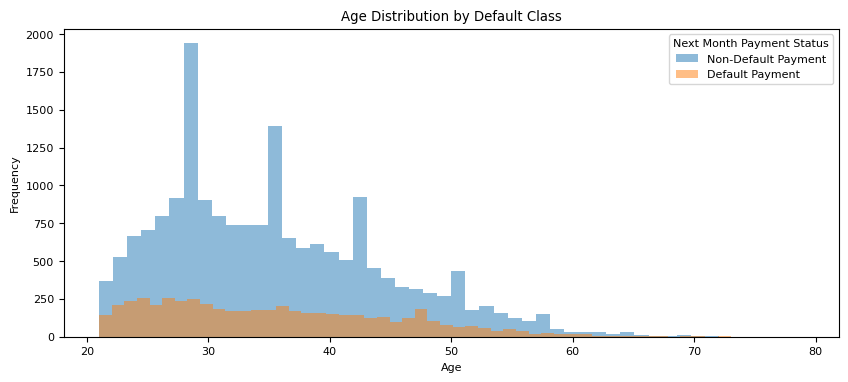

In [17]:
# Visualizing age distribution:
plt.figure(figsize = (10, 4))
plt.rcParams['font.size'] = 8

ax = train_df.groupby("default.payment.next.month")["AGE"].plot.hist(bins=50, alpha=0.5, legend=True)
plt.xlabel("Age")
plt.title("Age Distribution by Default Class")
plt.legend(["Non-Default Payment", "Default Payment"], title = "Next Month Payment Status")
plt.show()

In [9]:
summary = train_df.groupby(["default.payment.next.month"])["AGE"].count().to_frame().rename(columns = {"AGE": "Count"}).reset_index()
#summary['default.payment.next.month'].replace([0, 'Non-Default'], [1, 'Default'], inplace = True)
summary

,default.payment.next.month,Count
0,0,18691
1,1,5309


The age distribution for both groups appear to vary slightly. For users who does not have default payment on their card, most examples were in the 30s or 40s. This trend was different for the default payment group as the frequency remains quite stable for ages 20 to 40 then begins to slightly decrease.

* Next, I aim to examine clients' repayment status in September, 2005 as this was the last month before data was recorded.
     - For references on explanation of variables: https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/discussion/34608

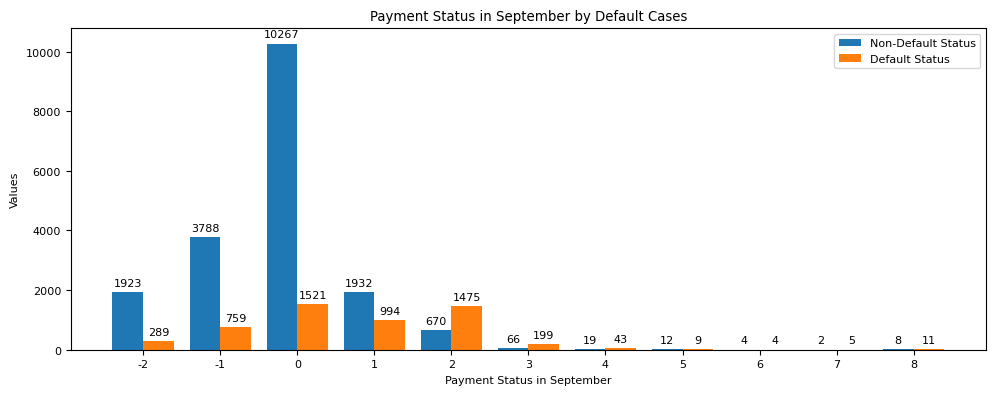

In [16]:
pay_0_summary = train_df.groupby(["default.payment.next.month", "PAY_0"])["AGE"].count().to_frame().reset_index().rename(columns = {"AGE": "Count"})

plt.figure(figsize = (10, 4))
plt.rcParams['font.size'] = 8

categories = np.unique(pay_0_summary["PAY_0"])
v1 = pay_0_summary[pay_0_summary["default.payment.next.month"] == 1]["Count"]
v2 = pay_0_summary[pay_0_summary["default.payment.next.month"] == 0]["Count"]
w, x = 0.4, np.arange(len(categories))

ax1 = plt.bar(x - w/2, v2, w, label='Non-Default Status')
plt.bar_label(ax1 , padding = 3)
ax2 = plt.bar(x + w/2, v1, w, label='Default Status')
plt.bar_label(ax2 , padding = 3)

plt.xticks(x, categories)
plt.xlabel('Payment Status in September')
plt.ylabel('Values')
plt.title('Payment Status in September by Default Cases')

plt.tight_layout()
plt.legend()
plt.show()

__It can be seen that most clients have default payment on their credit cards have delayed their payments for more than two months__

### D. PREPROCESSING AND TRANSFORMATION:

* In the dataset, there were different types of variables: numeric, categorical, ordinal. Therefore, I intend to apply different types of transforming techniques such as: scaling for numeric, one-hot encoding for categorical and binary.

* First, I will be checking if the dataset has any missing values as this may determines whether we might need imputation.

In [18]:
print(train_df.isnull().any())

LIMIT_BAL                     False
SEX                           False
EDUCATION                     False
MARRIAGE                      False
AGE                           False
PAY_0                         False
PAY_2                         False
PAY_3                         False
PAY_4                         False
PAY_5                         False
PAY_6                         False
BILL_AMT1                     False
BILL_AMT2                     False
BILL_AMT3                     False
BILL_AMT4                     False
BILL_AMT5                     False
BILL_AMT6                     False
PAY_AMT1                      False
PAY_AMT2                      False
PAY_AMT3                      False
PAY_AMT4                      False
PAY_AMT5                      False
PAY_AMT6                      False
default.payment.next.month    False
dtype: bool


* Since we have no missing values, no imputation is necessary.

In [19]:
## Identifying types of features and initiating types of transformers
categorical_features = ["EDUCATION", "MARRIAGE", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]
numeric_features = ["LIMIT_BAL", "BILL_AMT1", "BILL_AMT2","BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6",
                    "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]
binary_features = ["SEX"]
feature_names  = categorical_features + numeric_features + binary_features 
target = "default.payment.next.month"

ohe = OneHotEncoder(handle_unknown = "ignore")

scaler = StandardScaler()

ohe_binary = OneHotEncoder(drop = "if_binary")

In [20]:
## Defining column transformer
preprocessor = make_column_transformer(
    (scaler, numeric_features),
    (ohe, categorical_features),
    (ohe_binary, binary_features)
)

In [21]:
## Splitting into features and targets:

X_train = train_df.drop(columns = target)
y_train = train_df[target]
X_test = test_df.drop(columns = target)
y_test = test_df[target]

In [22]:
preprocessor.fit(X_train)
preprocessor.get_feature_names_out

<bound method ColumnTransformer.get_feature_names_out of ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2',
                                  'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
                                  'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
                                  'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
                                  'PAY_AMT6']),
                                ('onehotencoder-1',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2',
                                  'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']),
                                ('onehotencoder-2',
                                 OneHotEncoder(drop='if_binary'), ['SEX'])])>

In [23]:
transformed_df = pd.DataFrame(preprocessor.fit_transform(X_train))

### E. Training models and hyperparameter tuning:

* To begin this section, I would start with the baseline model in our prediction task. Further, to ensure that our training data go through the preprocessor defined above, I have also created a pipeline.

In [24]:
results_dict = {}

In [25]:
## Adapted from the CPSC 330: Applied Machine Learning course at the University of British Columbia for results summarizing purposes:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)


In [26]:
dummy = DummyClassifier(random_state = 42)
dummy_pipe = make_pipeline(preprocessor, dummy)

results_dict["Dummy Classifier"] = mean_std_cross_val_scores(dummy_pipe, X_train, y_train, 
                                                             cv = 5, return_train_score = True)


C:\Users\Admin\AppData\Local\Temp\ipykernel_16828\2577086146.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


In [27]:
pd.DataFrame(results_dict).T

,fit_time,score_time,test_score,train_score
Dummy Classifier,0.056 (+/- 0.010),0.012 (+/- 0.009),0.779 (+/- 0.000),0.779 (+/- 0.000)


* After a 5-fold cross validation, our Dummy Classifier model achieved an average of validation score of roughly 0.778

* Implementing the remaining models: Logistic Regression, Random Forest and Decision Tree:

In [28]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree Classifier": DecisionTreeClassifier(random_state = 123),
    "Random Forest": RandomForestClassifier(n_jobs = -1, random_state = 123)
}

for model_name in list(models.keys()):
    pipeline = make_pipeline(preprocessor, models[model_name])
    results_dict[model_name] = mean_std_cross_val_scores(models[model_name],
                                                         X_train,
                                                         y_train,
                                                         cv = 5,
                                                         return_train_score = True)

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [29]:
pd.DataFrame(results_dict).T

,fit_time,score_time,test_score,train_score
Dummy Classifier,0.056 (+/- 0.010),0.012 (+/- 0.009),0.779 (+/- 0.000),0.779 (+/- 0.000)
Logistic Regression,0.147 (+/- 0.026),0.004 (+/- 0.004),0.779 (+/- 0.000),0.779 (+/- 0.000)
Decision Tree Classifier,1.412 (+/- 0.045),0.003 (+/- 0.003),0.726 (+/- 0.008),1.000 (+/- 0.000)
Random Forest,3.965 (+/- 1.240),0.106 (+/- 0.016),0.815 (+/- 0.007),1.000 (+/- 0.000)


__SOME OBSERVATIONS__:
* It was surprising to notice that the Logistic Regression model performs just as well as the Dummy Classifier model. I expected that our logistic regression model would perform better as it took into account features while the Dummy Classifier only looks at target classes.
* Our Decision Tree classifier had the worst performance when it comes to validation score. This model also suffers from overfitting as we received a training score of 0.999. This may change as we experiment hyperparameter optimization.
* Random Forest had the optimal validation score. However, this model also experiences overfitting. This model also had the highest fitting time out of all models.

## Hyperparameter tuning for our random forest model:
* Given in our cross-validation summary table above, it is safe to assume that we can use our random forest model to deploy later on. In this part, I will be conducting a grid search to search across different values of parameters to find the optimal model)

In [30]:
##Hyperparameter tuning for a RandomForestClassifier:
##Reference: range of hyperparameters adapted from GeekForGeeks article on hyperparameter tuning

param_grid = {
    'n_estimators': [25, 50, 100, 150],
    'max_depth': [3,6, 9, 12],
}

gs = GridSearchCV(RandomForestClassifier(random_state = 123),
                        param_grid = param_grid,
                        n_jobs = -1,
                       return_train_score = True)
gs.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=123), n_jobs=-1,
             param_grid={'max_depth': [3, 6, 9, 12],
                         'n_estimators': [25, 50, 100, 150]},
             return_train_score=True)

In [31]:
gs.best_score_

0.8194583333333334

In [32]:
gs.best_params_

{'max_depth': 9, 'n_estimators': 150}

Overall, our random forest achieved its optimal performance with hyperparameters: `max_depth` = 9 and `n_estimators` = 50.

### F. DEPLOYMENT

Now that we have a random forest model, we will be retraining our random forest model with its optimal hyperparameter.

In [33]:
pipe_retrained = make_pipeline(preprocessor, 
                               RandomForestClassifier(max_depth = 9, n_estimators = 50, random_state = 123))
pipe_retrained.fit(X_train, y_train)
pipe_retrained.score(X_test, y_test)

0.8193333333333334

Our model achieved an accuracy rate of about 82%. However, this is calculated based on the number of correct predictions over total examples. This statistic may be misleading in the case of class imbalance. 

In [34]:
train_df["default.payment.next.month"].value_counts()

default.payment.next.month
0    18691
1     5309
Name: count, dtype: int64

The statistics above shows that the majority of examples in our training set are non-default cases. Therefore, using accuracy may not be the optimal metric to assess the performance of our model. In the code below, I will be using other metrics such as precision and recall.

In [35]:
from sklearn.metrics import classification_report

print(
    classification_report(
        y_test, pipe_retrained.predict(X_test), target_names = ["Non-default", "Default"], digits = 4
    )
)

              precision    recall  f1-score   support

 Non-default     0.8345    0.9581    0.8920      4673
     Default     0.6913    0.3308    0.4475      1327

    accuracy                         0.8193      6000
   macro avg     0.7629    0.6444    0.6698      6000
weighted avg     0.8028    0.8193    0.7937      6000



In [36]:
data = {
    "Importance": pipe_retrained.named_steps["randomforestclassifier"].feature_importances_,
}
importance_dt = pd.DataFrame(data=data, index = pipe_retrained[:-1].get_feature_names_out()).sort_values(
    by="Importance", ascending=False
)

top_10_most_important_features_dt = importance_dt[:10]
top_10_most_important_features_dt

,Importance
onehotencoder-1__PAY_0_2,0.172795
onehotencoder-1__PAY_2_2,0.117973
onehotencoder-1__PAY_3_2,0.059559
onehotencoder-1__PAY_5_2,0.049529
onehotencoder-1__PAY_4_2,0.039530
onehotencoder-1__PAY_0_0,0.037624
standardscaler__PAY_AMT1,0.037171
standardscaler__LIMIT_BAL,0.035500
onehotencoder-1__PAY_6_2,0.034865
standardscaler__BILL_AMT1,0.030052


In [37]:
importance_dt_bot = importance_dt[importance_dt["Importance"] == 0]
importance_dt_bot

,Importance
onehotencoder-1__PAY_2_8,0.0
onehotencoder-1__PAY_5_8,0.0
onehotencoder-1__PAY_3_1,0.0
onehotencoder-1__PAY_4_8,0.0
onehotencoder-1__EDUCATION_0,0.0
onehotencoder-1__PAY_6_8,0.0


### Experiment: SMOTE Resampling
- In our recent model, using Random Forest (our best performing model in terms of testing score) with selected optimal hyperparameters to train and predict on unseen data, we received a __recall (the percentage of actual payment default cases that was predicted correctly)__ of roughly 34%. 

- From my understanding, financial institutions may be more interested in having a model that could capture more default cases to help them make more reliable evaluations of credit applications. 

- To do so, this side experiment of the project will be using a technique called __SMOTE Resampling__ (in other words, we use our computer to generate more default cases using the trends within the pre-existing default cases). This will address the issue of class imbalance.

- __NOTE__: this method is not currently included in the main workflow due to potential bias that may present in default cases.

To do so, we follow the steps below:
* Declare a SMOTE algorithm and fit it into our training data.
* Use the resampled data to perform cross-validation across models and select the best performing model.
* Find optimal hyperparameters for the best performing models.
* Train the model and predict on new data.

In [27]:
sm = SMOTE(random_state=42, k_neighbors=5)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [34]:
results_dict_new = {}
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree Classifier": DecisionTreeClassifier(random_state = 123),
    "Random Forest": RandomForestClassifier(n_jobs = -1, random_state = 123)
}

for model_name in list(models.keys()):
    pipeline = make_pipeline(preprocessor, models[model_name])
    results_dict_new[model_name] = mean_std_cross_val_scores(models[model_name],
                                                         X_train_res,
                                                         y_train_res,
                                                         cv = 5,
                                                         return_train_score = True)

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [35]:
pd.DataFrame(results_dict_new).T

,fit_time,score_time,test_score,train_score
Logistic Regression,0.544 (+/- 0.052),0.011 (+/- 0.003),0.590 (+/- 0.019),0.591 (+/- 0.012)
Decision Tree Classifier,4.495 (+/- 0.118),0.014 (+/- 0.008),0.749 (+/- 0.059),0.999 (+/- 0.000)
Random Forest,12.520 (+/- 0.272),0.188 (+/- 0.009),0.840 (+/- 0.071),0.999 (+/- 0.000)


In [36]:
##Hyperparameter tuning for a RandomForestClassifier:
##Reference: range of hyperparameters adapted from GeekForGeeks article on hyperparameter tuning

param_grid = {
    'n_estimators': [25, 50, 100, 150],
    'max_depth': [3,6, 9, 12],
}

gs = GridSearchCV(RandomForestClassifier(random_state = 123),
                        param_grid = param_grid,
                        n_jobs = -1,
                       return_train_score = True)
gs.fit(X_train_res, y_train_res)

GridSearchCV(estimator=RandomForestClassifier(random_state=123), n_jobs=-1,
             param_grid={'max_depth': [3, 6, 9, 12],
                         'n_estimators': [25, 50, 100, 150]},
             return_train_score=True)

In [39]:
gs.best_score_
gs.best_params_

{'max_depth': 12, 'n_estimators': 150}

In [40]:
pipe_retrained = make_pipeline(preprocessor, 
                               RandomForestClassifier(max_depth = 12, n_estimators = 150, random_state = 123))
pipe_retrained.fit(X_train_res, y_train_res)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['LIMIT_BAL', 'BILL_AMT1',
                                                   'BILL_AMT2', 'BILL_AMT3',
                                                   'BILL_AMT4', 'BILL_AMT5',
                                                   'BILL_AMT6', 'PAY_AMT1',
                                                   'PAY_AMT2', 'PAY_AMT3',
                                                   'PAY_AMT4', 'PAY_AMT5',
                                                   'PAY_AMT6']),
                                                 ('onehotencoder-1',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['EDUCATION', 'MARRIAGE',
                                                   'PAY_0', 'PAY_2', 'PAY_3',
                                                   'PAY_4', 'PAY_5', 'PAY_6']),
                                                 ('onehotencoder-2',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['SEX'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=12, n_estimators=150,
                                        random_state=123))])

In [41]:
pipe_retrained.score(X_test, y_test)

0.7826666666666666

In [42]:
print(
    classification_report(
        y_test, pipe_retrained.predict(X_test), target_names = ["Non-default", "Default"], digits = 4
    )
)

              precision    recall  f1-score   support

 Non-default     0.8668    0.8519    0.8593      4673
     Default     0.5082    0.5388    0.5230      1327

    accuracy                         0.7827      6000
   macro avg     0.6875    0.6954    0.6912      6000
weighted avg     0.7874    0.7827    0.7849      6000



### G. CONCLUDING REMARKS:
* Overall, in this project, I have used four different machine learning models (DummyClassifier, Logistic Regression, Decision Tree and Random Forest) to predict the default payment status of credit card users. 
    - Throughout the cross-validating process, I found the Random Forest model appears to perform the best. However, this model suffers from overfitting as we achieve a high training score.
    - In hyperparameter tuning, I figured out our optimal hyperparameters and retrained our random forest model.
    - Due to class imbalance, I conclude that it is not the best option to use accuracy to evaluate our model. I used precision and recall as metrics of assessment instead. Observing the classification report above, our precision and recall score were much lower.

* Side experiment with SMOTE:
    - The model selection process also chose the Random Forest model with different hyperparameters.
    - While the SMOTE Resampling method improved recall score by 20%, we also sacrificed our precision score by 20%.
    - The SMOTE resampling technique might cause some bias, as these default cases are synthetically created, rather than being collected in real-life.
